In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Data Collection and Pre-Processing

In [ ]:
from sqlalchemy import create_engine, text
from db_config import DATABASE_CONFIG

In [ ]:
try:
    # Create the SQLAlchemy engine using the DATABASE_CONFIG from db_config.py
    connection_url = f"postgresql://{DATABASE_CONFIG['user']}:{DATABASE_CONFIG['password']}@{DATABASE_CONFIG['host']}:{DATABASE_CONFIG['port']}/{DATABASE_CONFIG['database']}"
    engine = create_engine(connection_url, connect_args={"sslmode": "require"})

    print(connection_url)
    # Optionally, read data into a DataFrame
    query = "SELECT * FROM crime_data_2020_to_present;"  # Example query
    with engine.connect() as conn:
        crime_data_2020_to_present_df = pd.read_sql(query, conn)
        print(crime_data_2020_to_present_df)

except Exception as e:
    print("Error while connecting to PostgreSQL:", e)

In [3]:
crime_data_2020_to_present_df[[
 'DATE OCC',
 'Vict Age',   
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Crm Cd',
 'Cross Street',
 'LAT',
 'LON']]

,DATE OCC,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Crm Cd,Cross Street,LAT,LON
0,03/01/2020 12:00:00 AM,0,M,O,101.0,STREET,NaN,NaN,510,NaN,34.0375,-118.3506
1,02/08/2020 12:00:00 AM,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,330,NaN,34.0444,-118.2628
2,11/04/2020 12:00:00 AM,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,480,NaN,34.0210,-118.3002
3,03/10/2020 12:00:00 AM,19,M,O,405.0,CLOTHING STORE,NaN,NaN,343,NaN,34.1576,-118.4387
4,09/09/2020 12:00:00 AM,0,NaN,NaN,101.0,STREET,NaN,NaN,510,NaN,34.0820,-118.2130
...,...,...,...,...,...,...,...,...,...,...,...,...
986868,07/23/2024 12:00:00 AM,0,NaN,NaN,101.0,STREET,NaN,NaN,510,NaN,34.0362,-118.3284
986869,01/15/2024 12:00:00 AM,0,X,X,503.0,HOTEL,500.0,UNKNOWN WEAPON/OTHER WEAPON,745,NaN,34.0685,-118.2460
986870,10/11/2024 12:00:00 AM,29,M,B,210.0,RESTAURANT/FAST FOOD,NaN,NaN,341,NaN,34.0675,-118.2240
986871,04/24/2024 12:00:00 AM,70,F,W,102.0,SIDEWALK,308.0,STICK,230,JEFFERSON BL,34.0215,-118.2868


In [ ]:
reduced_crime_df = df
# Saving the selected DataFrame to a CSV file
reduced_crime_df.to_csv("reduced_crime_df.csv", index=False)

print("CSV file 'reduced_crime_df.csv' saved successfully!")


## Further data cleaup and refinement

In [4]:
crime_data_2020_to_present_df['Vict Sex'].fillna('X', inplace = True)
crime_data_2020_to_present_df['Vict Sex'].replace(['H', '-'], 'X', inplace = True)
crime_data_2020_to_present_df['Vict Descent'].replace('-', 'Unknown', inplace = True)
crime_data_2020_to_present_df[['Vict Descent', 'Weapon Used Cd', 'Weapon Desc']] = crime_data_2020_to_present_df[['Vict Descent', 'Weapon Used Cd', 'Weapon Desc']].fillna('Unknown')
crime_data_2020_to_present_df.dropna(subset = ['Crm Cd 1'], inplace = True)
crime_data_2020_to_present_df.dropna(subset = ['Crm Cd'], inplace = True)

In [5]:
crime_data_2020_to_present_df['DateConvert'] = pd.to_datetime(crime_data_2020_to_present_df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
crime_data_2020_to_present_df['OCC MONTH'] = crime_data_2020_to_present_df['DateConvert'].dt.month
crime_data_2020_to_present_df['OCC YEAR'] = crime_data_2020_to_present_df['DateConvert'].dt.year

In [6]:
# Add violent crime  column
violent_codes = [830, 113, 436, 435, 760, 921, 920, 814, 943, 622, 122, 434, 922, 250, 822, 821, 235, 763, 820, 762, 647, 910, 902, 437, 231, 810, 815, 110, 251, 648, 623, 753, 627, 121, 860, 625, 220, 900, 901, 236, 930, 210, 626, 230, 624]

crime_data_2020_to_present_df['Violent_Crime'] = crime_data_2020_to_present_df['Crm Cd'].isin(violent_codes).astype(int)

In [7]:
## total number of violent crime records
violent_crime1_df = crime_data_2020_to_present_df[crime_data_2020_to_present_df['Violent_Crime'] == 1]
violent_crime1_df.shape[0]

299834

In [ ]:
# Dropping outliers and irrelevant crime codes when utilizing balanced data
drop_codes = [330, 345, 347, 349, 351, 353, 354, 410, 421, 432, 433, 438, 439, 441, 443, 444, 445, 446, 450, 451, 452, 453, 470, 471, 473, 474, 475, 485, 487, 510, 651, 652, 653, 654, 660, 661, 666, 670, 755, 756, 805, 806, 840, 865, 870, 880, 882, 884, 904, 906, 924, 926, 928, 931, 932, 933, 942, 944, 948, 949, 950, 951, 954, 343, 813, 845, 886, 888, 890, 903, 946, 956, 740]
for value in drop_codes:
    crime_data_2020_to_present_df = crime_data_2020_to_present_df[crime_data_2020_to_present_df['Crm Cd'] != value]

In [9]:
## total number of non-violent crime records
violent_crime0_df = crime_data_2020_to_present_df[crime_data_2020_to_present_df['Violent_Crime'] == 0]
violent_crime0_df.shape[0]

337661

In [10]:
crime_data_2020_to_present_df['OCC YEAR']

2         2020
6         2020
11        2020
15        2020
22        2020
          ... 
986866    2024
986867    2024
986869    2024
986870    2024
986871    2024
Name: OCC YEAR, Length: 637495, dtype: int32

In [22]:
df_2023 = crime_data_2020_to_present_df[crime_data_2020_to_present_df['OCC YEAR'] == 2023]
print('Total Crimes', df_2023.shape[0])
print('Total Violent Crimes', df_2023[df_2023['Violent_Crime'] == 1].shape[0])
print('Total Non-Violent Crimes', df_2023[df_2023['Violent_Crime'] == 0].shape[0])

Total Crimes 154067
Total Violent Crimes 72163
Total Non-Violent Crimes 81904


In [48]:
category_counts = df_2023['AREA'].value_counts()
print(category_counts)

AREA
1     11685
14    10226
12    10023
3      9658
6      8583
20     8535
7      8426
2      8400
13     8327
15     8133
18     8082
8      7636
9      7235
10     7193
17     7181
21     7040
11     6858
5      6559
19     6220
4      6208
16     5030
Name: count, dtype: int64


In [ ]:
df_AREA = crime_data_2020_to_present_df[crime_data_2020_to_present_df['AREA'] == 1]
print('Total Crimes', df_AREA.shape[0])
print('Total Violent Crimes', df_AREA[df_AREA['Violent_Crime'] == 1].shape[0])
print('Total Non-Violent Crimes', df_AREA[df_AREA['Violent_Crime'] == 0].shape[0])

Total Crimes 42687
Total Violent Crimes 21487
Total Non-Violent Crimes 21200


In [42]:
df_AREA_ONE_YEAR = df_AREA[df_AREA['OCC YEAR'] == 2023]
print('Total Crimes', df_AREA_ONE_YEAR.shape[0])
print('Total Violent Crimes', df_AREA_ONE_YEAR[df_AREA_ONE_YEAR['Violent_Crime'] == 1].shape[0])
print('Total Non-Violent Crimes', df_AREA_ONE_YEAR[df_AREA_ONE_YEAR['Violent_Crime'] == 0].shape[0])

Total Crimes 10650
Total Violent Crimes 5493
Total Non-Violent Crimes 5157


## Data Preperation

In [ ]:
## ALL YEARS

In [12]:
features = crime_data_2020_to_present_df[['AREA','Vict Age', 'Vict Sex', 'Vict Descent', 'Violent_Crime']]

df_cat = features.select_dtypes(include = 'object')
df_num = features.select_dtypes(include = [np.number])

from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()

for col in df_cat:
    if col not in ['Violent_Crime']:
        features[col] = Encoder.fit_transform(features[col])

features.corr()


C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\295227637.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = Encoder.fit_transform(features[col])
C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\295227637.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = Encoder.fit_transform(features[col])


,AREA,Vict Age,Vict Sex,Vict Descent,Violent_Crime
AREA,1.000000,0.016003,-0.029092,0.010491,-0.008733
Vict Age,0.016003,1.000000,-0.467420,-0.279850,0.127406
Vict Sex,-0.029092,-0.467420,1.000000,0.429082,-0.264388
Vict Descent,0.010491,-0.279850,0.429082,1.000000,-0.309739
Violent_Crime,-0.008733,0.127406,-0.264388,-0.309739,1.000000


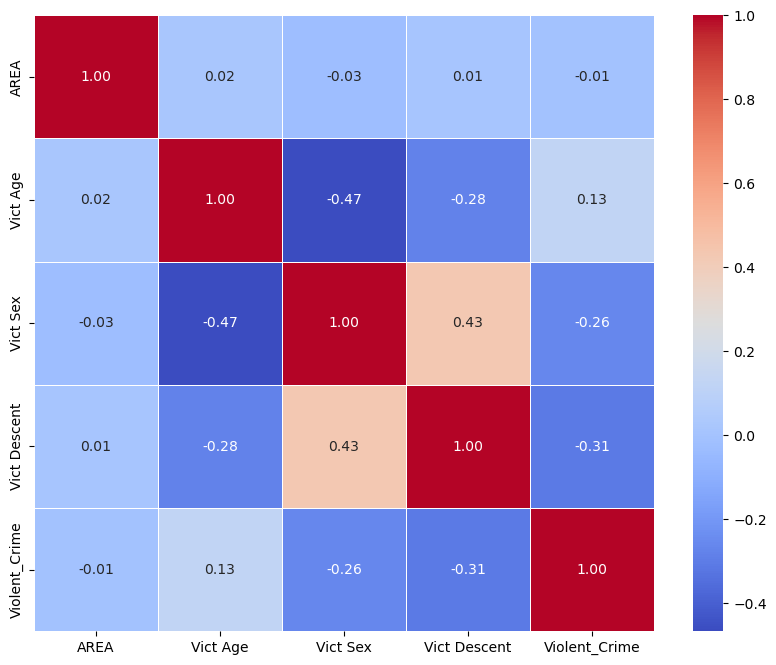

In [13]:
## Calculate correlation matrix to understand relationships, feature selection, and insight
import seaborn as sns
import matplotlib.pyplot as plt

corr = features.corr()  
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [14]:
sampled_df = features.sample(n=500000, random_state=42)

In [ ]:
## Individual YEARS

In [23]:
features_yr = df_2023[['AREA','Vict Age', 'Vict Sex', 'Vict Descent', 'Violent_Crime']]

df_cat = features_yr.select_dtypes(include = 'object')
df_num = features_yr.select_dtypes(include = [np.number])

from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()

for col in df_cat:
    if col not in ['Violent_Crime']:
        features_yr[col] = Encoder.fit_transform(features_yr[col])

features_yr.corr()

C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\3826362491.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_yr[col] = Encoder.fit_transform(features_yr[col])
C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\3826362491.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_yr[col] = Encoder.fit_transform(features_yr[col])


,AREA,Vict Age,Vict Sex,Vict Descent,Violent_Crime
AREA,1.000000,0.022335,-0.044691,0.006051,-0.006234
Vict Age,0.022335,1.000000,-0.490525,-0.301131,0.142650
Vict Sex,-0.044691,-0.490525,1.000000,0.454105,-0.277475
Vict Descent,0.006051,-0.301131,0.454105,1.000000,-0.317605
Violent_Crime,-0.006234,0.142650,-0.277475,-0.317605,1.000000


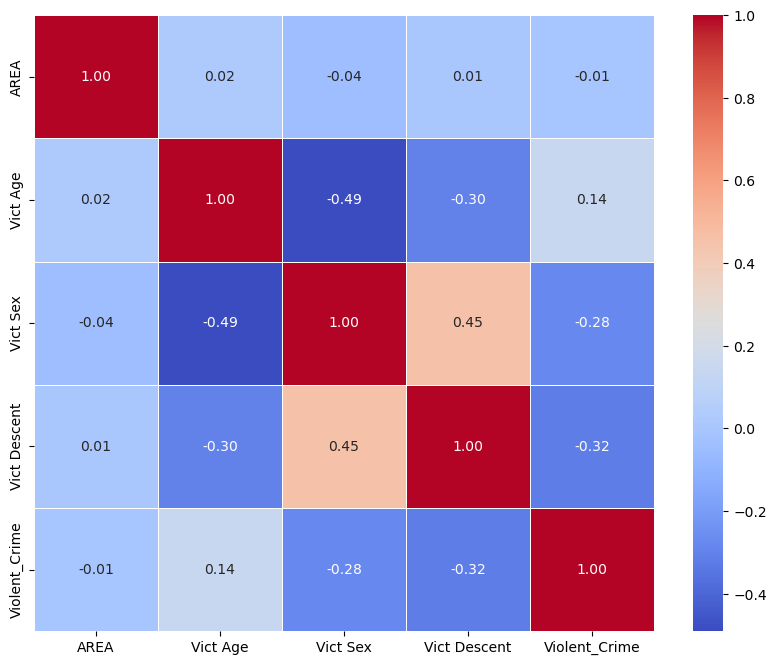

In [24]:
## Calculate correlation matrix to understand relationships, feature selection, and insight
import seaborn as sns
import matplotlib.pyplot as plt

corr = features_yr.corr()  
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [25]:
sampled_yr_df = features_yr.sample(n=100000, random_state=42)

In [ ]:
## Individual AREA

In [33]:
features_area = df_AREA[['Vict Age', 'Vict Sex', 'Vict Descent', 'Violent_Crime']]

df_cat = features_area.select_dtypes(include = 'object')
df_num = features_area.select_dtypes(include = [np.number])

from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()

for col in df_cat:
    if col not in ['Violent_Crime']:
        features_area[col] = Encoder.fit_transform(features_area[col])

features_area.corr()

C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\3913417856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_area[col] = Encoder.fit_transform(features_area[col])
C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\3913417856.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_area[col] = Encoder.fit_transform(features_area[col])


,Vict Age,Vict Sex,Vict Descent,Violent_Crime
Vict Age,1.000000,-0.430448,-0.349780,0.210090
Vict Sex,-0.430448,1.000000,0.387968,-0.218307
Vict Descent,-0.349780,0.387968,1.000000,-0.224450
Violent_Crime,0.210090,-0.218307,-0.224450,1.000000


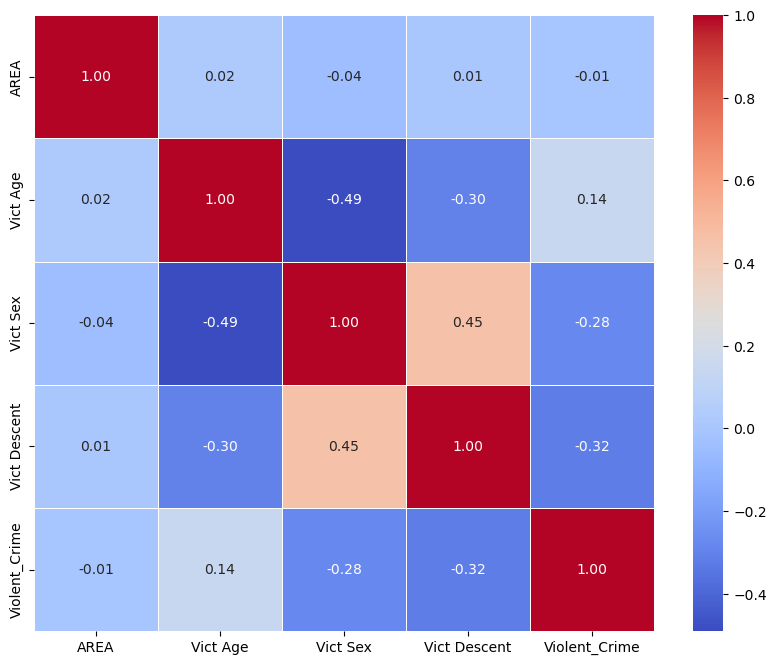

In [34]:
## Calculate correlation matrix to understand relationships, feature selection, and insight
import seaborn as sns
import matplotlib.pyplot as plt

corr = features_yr.corr()  
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [35]:
sampled_area_df = features_area.sample(n=40000, random_state=42)

In [ ]:
## Individual AREA one year

In [43]:
features_area_one_year = df_AREA_ONE_YEAR[['Vict Age', 'Vict Sex', 'Vict Descent', 'Violent_Crime']]

df_cat = features_area_one_year.select_dtypes(include = 'object')
df_num = features_area_one_year.select_dtypes(include = [np.number])

from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()

for col in df_cat:
    if col not in ['Violent_Crime']:
        features_area_one_year[col] = Encoder.fit_transform(features_area_one_year[col])

features_area_one_year.corr()

C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\1265047034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_area_one_year[col] = Encoder.fit_transform(features_area_one_year[col])
C:\Users\jesus\AppData\Local\Temp\ipykernel_26604\1265047034.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_area_one_year[col] = Encoder.fit_transform(features_area_one_year[col])


,Vict Age,Vict Sex,Vict Descent,Violent_Crime
Vict Age,1.000000,-0.448152,-0.354750,0.214059
Vict Sex,-0.448152,1.000000,0.410772,-0.199295
Vict Descent,-0.354750,0.410772,1.000000,-0.216682
Violent_Crime,0.214059,-0.199295,-0.216682,1.000000


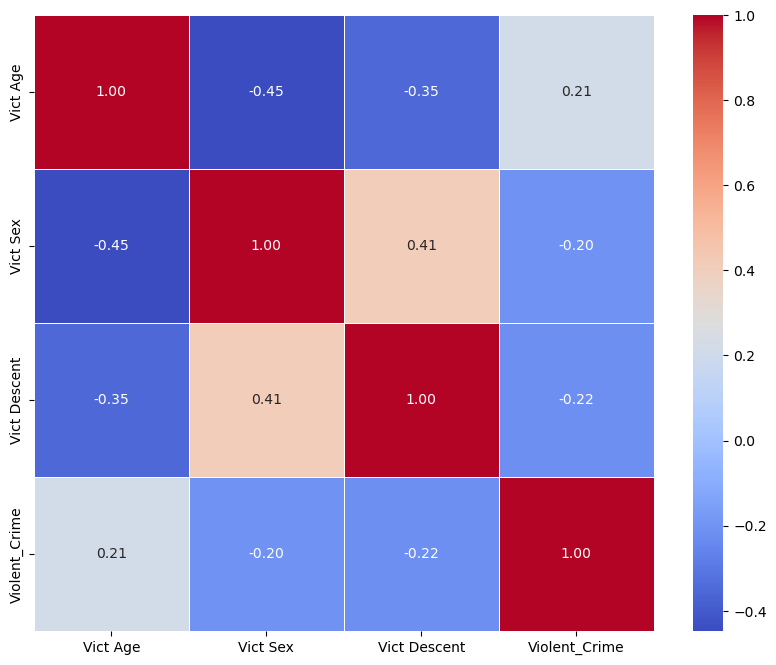

In [46]:
## Calculate correlation matrix to understand relationships, feature selection, and insight
import seaborn as sns
import matplotlib.pyplot as plt

corr = features_area_one_year.corr()  
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [47]:
sampled_area_df_one_year = features_area_one_year.sample(n=10000, random_state=42)

In [15]:
# TEST 1
X = sampled_df[['Vict Age', 'Vict Sex', 'Vict Descent']]
y = sampled_df['Violent_Crime']

In [43]:
# TEST 2 - Balanced
x = sampled_df[['Vict Age', 'Vict Sex', 'Vict Descent']]
y = sampled_df['Violent_Crime']

In [98]:
# TEST 3
X = sampled_df[[ 'Vict Sex']]
y = sampled_df['Violent_Crime']

In [26]:
# TEST 4 by YEAR
X = sampled_yr_df[['Vict Age', 'Vict Sex', 'Vict Descent']]
y = sampled_yr_df['Violent_Crime']

In [36]:
# TEST 5 by AREA
X = sampled_area_df[['Vict Age','Vict Sex', 'Vict Descent']]
y = sampled_area_df['Violent_Crime']

In [48]:
# TEST 5 by AREA one Year
X = sampled_area_df_one_year[['Vict Age','Vict Sex', 'Vict Descent']]
y = sampled_area_df_one_year['Violent_Crime']

## Scaling the Dataset / Spit into training and testing

In [49]:
from sklearn.preprocessing import StandardScaler

Scale = StandardScaler()

X_Scaled = Scale.fit_transform(X)

X = pd.DataFrame(X_Scaled, columns = X.columns)

In [50]:


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (8000, 3)
y_train (8000,)
X_test (2000, 3)
y_test (2000,)


## Logistic Regression

## Test 1 


In [18]:
model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.6534425
Accuracy score of our test data: 0.65295


In [19]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66    211622
           1       0.62      0.68      0.65    188378

    accuracy                           0.65    400000
   macro avg       0.65      0.65      0.65    400000
weighted avg       0.66      0.65      0.65    400000



In [20]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66     53311
           1       0.62      0.68      0.65     46689

    accuracy                           0.65    100000
   macro avg       0.65      0.65      0.65    100000
weighted avg       0.66      0.65      0.65    100000



## Test 2

In [46]:

model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.529055
Accuracy score of our test data: 0.53311


In [47]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69    211622
           1       0.00      0.00      0.00    188378

    accuracy                           0.53    400000
   macro avg       0.26      0.50      0.35    400000
weighted avg       0.28      0.53      0.37    400000



c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.70     53311
           1       0.00      0.00      0.00     46689

    accuracy                           0.53    100000
   macro avg       0.27      0.50      0.35    100000
weighted avg       0.28      0.53      0.37    100000



c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## TEST 3

In [101]:
model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.59208
Accuracy score of our test data: 0.59122


In [102]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.68      0.64    211622
           1       0.58      0.49      0.53    188378

    accuracy                           0.59    400000
   macro avg       0.59      0.59      0.58    400000
weighted avg       0.59      0.59      0.59    400000



In [103]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.69      0.64     53311
           1       0.57      0.48      0.53     46689

    accuracy                           0.59    100000
   macro avg       0.59      0.58      0.58    100000
weighted avg       0.59      0.59      0.59    100000



## TEST 4 by year

In [29]:
model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.6506
Accuracy score of our test data: 0.6484


In [30]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67     42675
           1       0.62      0.64      0.63     37325

    accuracy                           0.65     80000
   macro avg       0.65      0.65      0.65     80000
weighted avg       0.65      0.65      0.65     80000



In [31]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67     10688
           1       0.62      0.64      0.63      9312

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



# TEST 5 by AREA

In [39]:
model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.6115625
Accuracy score of our test data: 0.608125


In [40]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.53      0.58     15884
           1       0.60      0.69      0.64     16116

    accuracy                           0.61     32000
   macro avg       0.61      0.61      0.61     32000
weighted avg       0.61      0.61      0.61     32000



In [41]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.52      0.57      3985
           1       0.59      0.69      0.64      4015

    accuracy                           0.61      8000
   macro avg       0.61      0.61      0.61      8000
weighted avg       0.61      0.61      0.61      8000



In [ ]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.52      0.57      3985
           1       0.59      0.69      0.64      4015

    accuracy                           0.61      8000
   macro avg       0.61      0.61      0.61      8000
weighted avg       0.61      0.61      0.61      8000



# TEST 6 by AREA ONE YEAR

In [51]:
model = LogisticRegression()
model.fit(X_train,y_train)

# train accuracy
X_train_prediction  = model.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction,y_train)

print('Accuracy score of our train data:',train_data_accuracy)

# test accuracy
X_test_prediction  = model.predict(X_test)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
test_data_accuracy = accuracy_score(X_test_prediction,y_test)

print('Accuracy score of our test data:',test_data_accuracy)

Accuracy score of our train data: 0.606625
Accuracy score of our test data: 0.622


In [52]:
# classification reports for training data
print("Logistic Regression Classification Report:\n", classification_report(y_train, X_train_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.44      0.52      3864
           1       0.59      0.76      0.67      4136

    accuracy                           0.61      8000
   macro avg       0.61      0.60      0.59      8000
weighted avg       0.61      0.61      0.60      8000



In [53]:
# classification reports for test data
print("Logistic Regression Classification Report:\n", classification_report(y_test, X_test_prediction))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.45      0.54      1001
           1       0.59      0.80      0.68       999

    accuracy                           0.62      2000
   macro avg       0.64      0.62      0.61      2000
weighted avg       0.64      0.62      0.61      2000

